## 減掉連續譜
應該是**連續譜的 fitting**

因為我的 cube 看起來（也確實是）沒減過連續譜的樣子  
這樣算比值絕對會出問題的吧啊！  
所以要先做這個  

ref :  
Jet-mode feedback in NGC 5972: insights from resolved MUSE, GMRT and VLA observations  
https://iopscience.iop.org/article/10.3847/1538-4357/adc38d/pdf  

處理的 cube :  
從 ESO 上抓下來的，觀測儀器是 MUSE(single)  
統一使用波長單位:4759-9320 ang（補藥換成頻率啊）  
pID = 094.B-0321

In [66]:
# modular

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

from ppxf.ppxf import ppxf
from ppxf.ppxf_util import log_rebin
import ppxf.ppxf_util as util
import ppxf.sps_util as lib 

### Setup MUSE data
因為和老哥用的不是同一個儀器的數據  
所以我在這邊要死要活的

In [67]:
# 
c = 299792.458  # [km/s]
z = 0.001448 # circinus galaxy
file_path = "/Users/aqing/Documents/1004/Circinus_galaxy/ionized-gas/VLT/MUSE_PID-094.B-0321_cube_4750-9352a_circinus.fits" # FITS

# metadata
muse_hdul = fits.open(file_path)
muse_hdul.info() # DATA:cube, STAT:noise?
muse_data = muse_hdul['DATA'].data # (RA, DEC, AWAV)
muse_header = muse_hdul['DATA'].header

muse_stat = muse_hdul['STAT'] # 不知道這是什麼
print(muse_stat)

Filename: /Users/aqing/Documents/1004/Circinus_galaxy/ionized-gas/VLT/MUSE_PID-094.B-0321_cube_4750-9352a_circinus.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU    1341   ()      
  1  DATA          1 ImageHDU        43   (317, 319, 3682)   float32   
  2  STAT          1 ImageHDU        43   (317, 319, 3682)   float32   


#### Make WL & spec axis
 製作波長軸以及光譜軸  

In [68]:
# original AWV axis
crval3 = muse_header['CRVAL3']
cdelt3 = muse_header['CD3_3']
crpix3 = muse_header['CRPIX3']
naxis3 = muse_header['NAXIS3']
ori_lamb = crval3 + (np.arange(naxis3) + 1 - crpix3) * cdelt3 # [AA] in air

# original spectrum intensity axis (flux)
print(f"Original WAV axis's shape = {ori_lamb.shape}")
i, j = muse_data.shape[1]//2, muse_data.shape[2]//2 # certain pixel, 之後應該是要 gothrogh 的
ori_flux_unnorm = muse_data[:, i, j]
if ori_flux_unnorm.shape==ori_lamb.shape : # 他媽的這本來就要一樣吧
    print('Nice ^_-!')

Original WAV axis's shape = (3682,)
Nice ^_-!


#### Futher processing of that two axis
- 對數、真空和air  
- 正規化、考慮噪音

Velocity resolu(?) on ln-WAV axis = 55.17 (km/s)



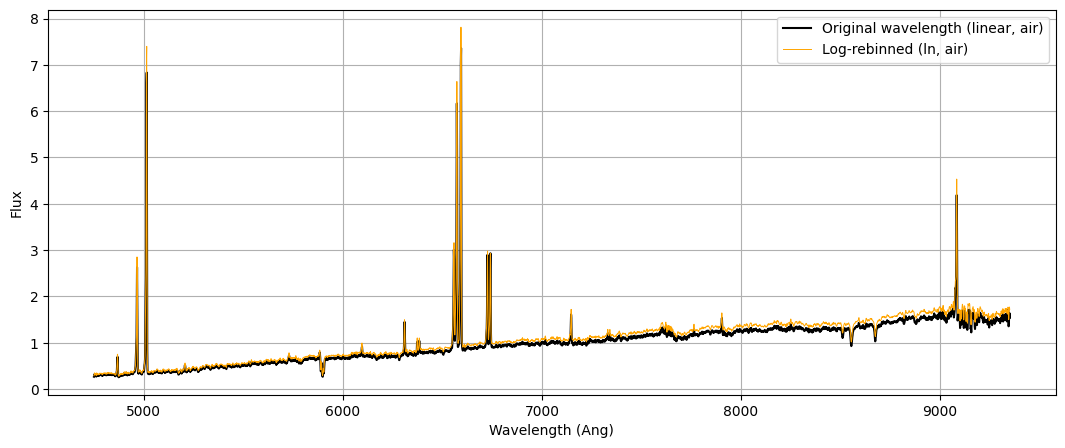

In [69]:
# Log(ln) waveLen array
ln_flux_unnorm, ln_lamb_pix, veloScale = log_rebin([ori_lamb[0], ori_lamb[-1]], ori_flux_unnorm)
print(f"Velocity resolu(?) on ln-WAV axis = {veloScale:.2f} (km/s)", end='\n\n')
# veloScale 算好了喔好方便捏
ln_lamb = np.exp(ln_lamb_pix) # 從 ln(lambda) 換成 AA


# flux normalization
def flux_Norm(flux): # 除到 nan 中位數的話，就會爆炸，所以做了這個
    flux_no_nan = flux[~np.isnan(flux)]
    if len(flux_no_nan) > 10 and np.nanmedian(flux_no_nan) != 0:
        return flux / np.nanmedian(flux_no_nan)
    else:
        return flux

ln_flux = flux_Norm(ln_flux_unnorm) # 沒標 un- 就是正規化了
ori_flux = flux_Norm(ori_flux_unnorm) # 等下畫圖的時候用一下而已

# consider noise
noise = np.full_like(ln_flux, 0.0149) # 隨便設一個數字...

# (waveLen) air --> vaccum
# The SDSS wavelengths are in vacuum, while the MILES ones are in air.(micappe 老哥)
# 所以我不用做這個

# 畫出來看看
plt.figure(figsize=(13, 5))
plt.plot(ori_lamb, ori_flux, c='k', label='Original wavelength (linear, air)')
plt.plot(ln_lamb, ln_flux, c='orange', lw=0.7, label='Log-rebinned (ln, air)', linestyle='-') # 大便般的配色
plt.xlabel("Wavelength (Ang)")
plt.ylabel("Flux")
plt.legend()
plt.grid()
plt.show()


#### Check array quality
檢查下等下要拿去算的東西裡面有沒有 NaN, infinite

In [70]:
print('Bad value in ln_flux: ', end='')
print(f'{np.isnan(ln_flux).sum()} NaN, {np.isinf(ln_flux).sum()} inf') #1 NaN
ln_flux_clean = np.copy(ln_flux)
ln_flux_clean[~np.isfinite(ln_flux_clean)] = 0

print('Bad value in noise: ', end='')
print(f'{np.isnan(noise).sum()} NaN, {np.isinf(noise).sum()} inf') # 0, 0

Bad value in ln_flux: 1 NaN, 0 inf
Bad value in noise: 0 NaN, 0 inf


#### something ELSE

In [71]:
dlam = np.gradient(ln_lamb)          # how many AA is a pixel (like CD3_3, but CD3_3 is for liner sampling)
fwhm = np.full(3682, 2.5)            # [AA] #### 先隨便設了，要放成一長串的
                                     # Resolution FWHM of every pixel, in Angstroms
# r-shift
ln_lamb = ln_lamb / (1+z)
fwhm = fwhm / (1+z)

### Setup stellar templates

In [72]:
temp_path = '/Users/aqing/Documents/1004/Circinus_galaxy/ionized-gas/VLT/spectra_emiles_9.0.npz'

In [ ]:
tempRange_lamb = [4500, 9500] # 是出來這樣最好，反正有覆蓋到就好哩
fwhmD = {"lam": ln_lamb, "fwhm": fwhm} # 字典 for 因為不同波長可能對應不同解析度（儀器），但現在找不到資料所以都給他設成一樣的 fwhm

#print(type(ln_lamb), ln_lamb.dtype)
sps = lib.sps_lib(temp_path, veloScale, fwhmD, lam_range=tempRange_lamb) # 讀模型
goodpixs = util.determine_goodpixels(np.log(ln_lamb), tempRange_lamb) # 找出沒污染之類的 pix，備料
# 超好笑有個瓠瓜昨天三十分鐘抓不出一個蟲
# 果然人要先吃飽再做事...
# 而且這邊很好笑，要 run all 才不會報 sps 那行的錯
print(goodpixs) # 和老哥的長差不多，好呢

[   0    1    2 ... 3679 3680 3681]


### FITTING
終於可以 fe 了嗎，感覺等下一定會大報錯 嗚嗚

---

**超級加粗**  
**啊啊啊啊啊啊啊做出來了！雖然很多參數是他媽亂射的蛋就是今天先，這個，嗚嗚**

In [90]:
vel = 0                 # Spectrum is de-redshifted --> starting guess is zero
start = [vel, 200.]     # (km/s), starting guess for [V, sigma] # 不知道為什ㄕㄜ這個

feee = ppxf(sps.templates, ln_flux_clean, noise, veloScale, start,
          goodpixels=goodpixs, plot=False, moments=4, trig=1, # 這邊的參數並不是全部都知道什麼意思
          degree=20, lam=ln_lamb, lam_temp=sps.lam_temp)

plt.figure(figsize=(13, 5))
feee.plot()
plt.title(f"pPXF fit with SPS-EMILEs templates")
#plt.pause(5)


AssertionError: The `templates` must cover the full wavelength range of the `galaxy[goodpixels]` spectrum for the adopted velocity starting guess